In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_csv("D:\Brandeis Homework\kaggle competition\2019Cnov\coronavirus.csv").drop(['Unnamed: 0'],axis=1).csv

In [4]:
print(data)

    date  confirm  suspect  dead  heal
0   1.13       41        0     1     0
1   1.14       41        0     1     0
2   1.15       41        0     2     5
3   1.16       45        0     2     8
4   1.17       62        0     2    12
5   1.18      198        0     3    17
6   1.19      275        0     4    18
7   1.20      291       54     6    25
8   1.21      440       37     9    25
9   1.22      571      393    17    25
10  1.23      830     1072    25    34
11  1.24     1287     1965    41    38
12  1.25     1975     2684    56    49
13  1.26     2744     5794    80    51
14  1.27     4515     6973   106    60
15  1.28     5974     9239   132   103
16  1.29     7711    12167   170   124
17  1.30     9692    15238   213   171
18  1.31    11791    17988   259   243
19  2.01    14380    19544   304   328
20  2.02    17205    21558   361   475


In [5]:
model = VAR(data.drop(['date'],axis=1)[:16])

In [6]:
result = model.fit(1)

In [7]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Feb, 2020
Time:                     19:08:48
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    24.5976
Nobs:                     15.0000    HQIC:                   23.6435
Log likelihood:          -242.538    FPE:                2.08254e+10
AIC:                      23.6535    Det(Omega_mle):     6.58929e+09
--------------------------------------------------------------------
Results for equation confirm
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -2.765967        20.586939           -0.134           0.893
L1.confirm         0.421914         0.057305            7.363           0.000
L1.suspect         0.395091         0.036544           10.811         

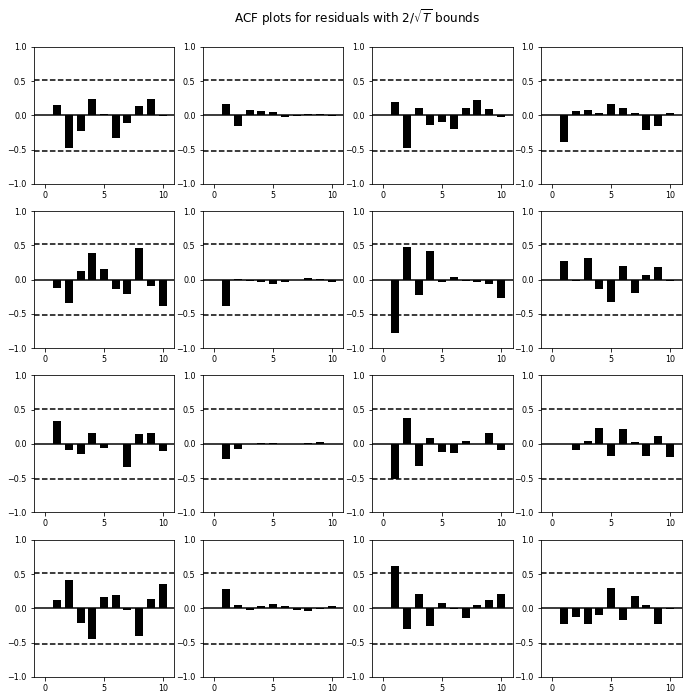

In [8]:
plot = result.plot_acorr()

In [9]:
lag_order = result.k_ar
var_forcast = result.forecast(data.drop(['date'],axis=1)[:16].values[-lag_order:], 5)
print(var_forcast)

[[ 8113.04495473 11120.43259227   165.60974562   150.77504256]
 [10486.09147802 13735.9650753    207.4536046    220.27989614]
 [13533.98303272 16776.62117031   263.22813637   305.10258948]
 [17287.71310706 21089.47587754   338.43561742   411.30565872]
 [22195.15068683 27003.19176866   441.11261515   538.97424676]]


In [10]:
ar_model = AutoReg(data['suspect'][:16],1)

In [11]:
ar_result = ar_model.fit()

In [12]:
ar_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                suspect   No. Observations:                   16
Model:                     AutoReg(1)   Log Likelihood                -117.496
Method:               Conditional MLE   S.D. of innovations            610.400
Date:                Tue, 04 Feb 2020   AIC                             13.228
Time:                        19:08:50   BIC                             13.370
Sample:                             1   HQIC                            13.227
                                   16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    222.6604    182.442      1.220      0.222    -134.920     580.241
suspect.L1     1.3109      0.073     18.042      0.000       1.169       1.453
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7628           +0.0000j            0.7628            0.0000
-----------------------------------------------------------------------------
"""

In [13]:
reg_con = LinearRegression(fit_intercept=False).fit(data['suspect'][:15].values.reshape(-1,1), data['confirm'][1:16])
reg_dead = LinearRegression(fit_intercept=False).fit(data['confirm'][:15].values.reshape(-1,1), data['dead'][1:16])
reg_heal = LinearRegression(fit_intercept=False).fit(data['confirm'][:15].values.reshape(-1,1), data['heal'][1:16])

In [14]:
reg_con.score(data['suspect'][:15].values.reshape(-1,1), data['confirm'][1:16])

0.9668478833915429

In [15]:
reg_dead.score(data['confirm'][:15].values.reshape(-1,1), data['dead'][1:16])

0.9540749587447863

In [16]:
reg_heal.score(data['confirm'][:15].values.reshape(-1,1), data['heal'][1:16])

0.7373836558531137

In [17]:
def mod_predict(data, times):
    dum = np.zeros((times,4),dtype=float)
    dum[:,1] = ar_result.predict(-1,15+times)[-times:]
    dum[:,0] = reg_con.predict(np.concatenate((data.values[:,1], dum[:-1,1]),axis=0).reshape(-1,1))
    dum[:,2] = reg_dead.predict(np.concatenate((data.values[:,0], dum[:-1,0]),axis=0).reshape(-1,1))
    dum[:,3] = reg_heal.predict(np.concatenate((data.values[:,0], dum[:-1,0]),axis=0).reshape(-1,1))
    return dum

In [18]:
mod_forcast = mod_predict(data.drop(['date'],axis=1)[15:16],5)
print(mod_forcast)

[[ 7895.34460376 12334.40569559   201.73914684   149.86366953]
 [10540.57619324 16392.286984     266.62204292   198.06248988]
 [14008.30767209 21711.91296202   355.9502592    264.4207277 ]
 [18554.28453751 28685.60650669   473.05390667   351.41218474]
 [24513.77297741 37827.67812151   626.5693895    465.4524885 ]]


In [19]:
var_data = np.concatenate((data.drop(['date'],axis=1).values[:-5],var_forcast),axis=0)
mod_data = np.concatenate((data.drop(['date'],axis=1).values[:-5],mod_forcast),axis=0)

In [20]:
var_data = pd.DataFrame(var_data,columns=['confirm','suspect','dead','heal'])
mod_data = pd.DataFrame(mod_data,columns=['confirm','suspect','dead','heal'])

In [21]:
print(var_data)

         confirm       suspect        dead        heal
0      41.000000      0.000000    1.000000    0.000000
1      41.000000      0.000000    1.000000    0.000000
2      41.000000      0.000000    2.000000    5.000000
3      45.000000      0.000000    2.000000    8.000000
4      62.000000      0.000000    2.000000   12.000000
5     198.000000      0.000000    3.000000   17.000000
6     275.000000      0.000000    4.000000   18.000000
7     291.000000     54.000000    6.000000   25.000000
8     440.000000     37.000000    9.000000   25.000000
9     571.000000    393.000000   17.000000   25.000000
10    830.000000   1072.000000   25.000000   34.000000
11   1287.000000   1965.000000   41.000000   38.000000
12   1975.000000   2684.000000   56.000000   49.000000
13   2744.000000   5794.000000   80.000000   51.000000
14   4515.000000   6973.000000  106.000000   60.000000
15   5974.000000   9239.000000  132.000000  103.000000
16   8113.044955  11120.432592  165.609746  150.775043
17  10486.

In [22]:
print(mod_data)

         confirm       suspect        dead        heal
0      41.000000      0.000000    1.000000    0.000000
1      41.000000      0.000000    1.000000    0.000000
2      41.000000      0.000000    2.000000    5.000000
3      45.000000      0.000000    2.000000    8.000000
4      62.000000      0.000000    2.000000   12.000000
5     198.000000      0.000000    3.000000   17.000000
6     275.000000      0.000000    4.000000   18.000000
7     291.000000     54.000000    6.000000   25.000000
8     440.000000     37.000000    9.000000   25.000000
9     571.000000    393.000000   17.000000   25.000000
10    830.000000   1072.000000   25.000000   34.000000
11   1287.000000   1965.000000   41.000000   38.000000
12   1975.000000   2684.000000   56.000000   49.000000
13   2744.000000   5794.000000   80.000000   51.000000
14   4515.000000   6973.000000  106.000000   60.000000
15   5974.000000   9239.000000  132.000000  103.000000
16   7895.344604  12334.405696  201.739147  149.863670
17  10540.